# Project NYC taxi and Limousine trips__


import findspark
findspark.init()
import pyspark
import numpy as np
from random import random
import pandas as pd
from pyspark import SparkConf, SparkContext
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg import SparseVector
from pyspark.mllib.stat import Statistics
from scipy import stats
import datetime
from pyspark.mllib.clustering import KMeans, KMeansModel

import matplotlib
import matplotlib.pyplot
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
port = 4040 + hash(os.getcwd().split("/")[2])%200
config = pyspark.SparkConf().set('spark.executor.memory', '512M')\
         .set('spark.cores.max', '8')\
         .set('spark.port.maxRetries','200')\
         .set('spark.ui.port', port)    
print port,     os.getcwd().split("/")[2]

4182 zhl617


In [3]:
sc = pyspark.SparkContext(appName="Project 1", master='spark://polyp1:7077',conf = config )

In [4]:
dataHeader = sc.textFile("/scratch/ISE495/2018_project_01/header.txt")
print dataHeader.collect()

[u'VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,Trip_distance,Fare_amount,Extra,MTA_tax,Tip_amount,Tolls_amount,Ehail_fee,improvement_surcharge,Total_amount,Payment_type,Trip_type']


In [5]:
data = sc.textFile("/scratch/ISE495/2018_project_01/green_tripdata_2015-09.csv")
#data = sc.textFile("/scratch/ISE495/2018_project_01/green_tripdata_2015-09_small.csv")

print data.take(5)

[u'2,2015-09-01 00:02:34,2015-09-01 00:02:38,N,5,-73.979484558105469,40.684955596923828,-73.97943115234375,40.685020446777344,1,.00,7.8,0,0,1.95,0,,0,9.75,1,2', u'2,2015-09-01 00:04:20,2015-09-01 00:04:24,N,5,-74.010795593261719,40.912216186523438,-74.010780334472656,40.912212371826172,1,.00,45,0,0,0,0,,0,45,1,2', u'2,2015-09-01 00:01:50,2015-09-01 00:04:24,N,1,-73.921409606933594,40.766708374023438,-73.914413452148438,40.764686584472656,1,.59,4,0.5,0.5,0.5,0,,0.3,5.8,1,1', u'2,2015-09-01 00:02:36,2015-09-01 00:06:42,N,1,-73.92138671875,40.766677856445313,-73.931427001953125,40.771583557128906,1,.74,5,0.5,0.5,0,0,,0.3,6.3,2,1', u'2,2015-09-01 00:00:14,2015-09-01 00:04:20,N,1,-73.955482482910156,40.714046478271484,-73.944412231445313,40.714729309082031,1,.61,5,0.5,0.5,0,0,,0.3,6.3,2,1']


In [6]:
##datacleaning and transforming

In [7]:
sdata = data.map(lambda x:x.split(','))
transform = sdata.map(lambda x:[x[0]]+[datetime.datetime.strptime(i, "%Y-%m-%d %H:%M:%S") for i in x[1:3]]+[x[3]]+[float(i) for i in x[4:16]]+[x[16]]+[abs(float(i)) for i in x[17:20]]+[x[20]])

print transform.take(1)


cleandata = transform.filter(lambda x:x[4:9] != 0).filter(lambda x:  0<x[10]<80).filter(lambda x:  0<=x[14]<100).filter(lambda x:x[14:15]>=0)
cleandata.count()


[[u'2', datetime.datetime(2015, 9, 1, 0, 2, 34), datetime.datetime(2015, 9, 1, 0, 2, 38), u'N', 5.0, -73.97948455810547, 40.68495559692383, -73.97943115234375, 40.685020446777344, 1.0, 0.0, 7.8, 0.0, 0.0, 1.95, 0.0, u'', 0.0, 9.75, 1.0, u'2']]


1474281

In [8]:
## We plotted all the pickup and dropoff locations 

(40.61, 40.87)

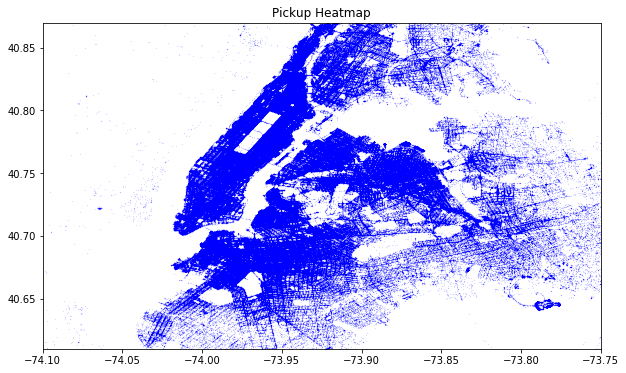

In [9]:
longitude_border = (-74.10, -73.75)
latitude_border = (40.61, 40.87)
drop_longitude = cleandata.map(lambda x:x[7]).collect()
drop_latitude = cleandata.map(lambda x:x[8]).collect()
plt.figure(figsize=(10,6))
plt.scatter( drop_longitude, drop_latitude, color='b',alpha=0.5,s=0.01)
plt.title("Dropoff Heatmap")

plt.xlim(longitude_border)
plt.ylim(latitude_border)

(40.61, 40.87)

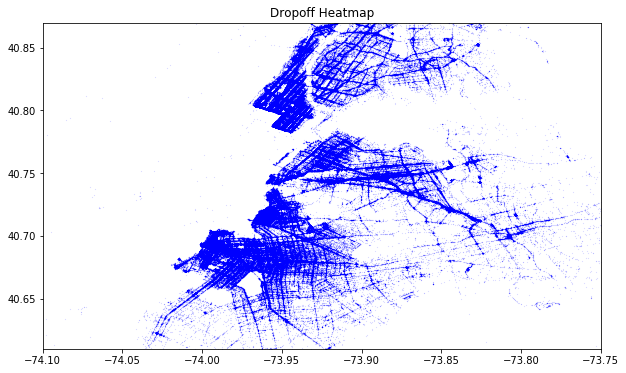

In [10]:
longitude_border = (-74.10, -73.75)
latitude_border = (40.61, 40.87)
drop_longitude = cleandata.map(lambda x:x[5]).collect()
drop_latitude = cleandata.map(lambda x:x[6]).collect()
plt.figure(figsize=(10,6))
plt.scatter( drop_longitude, drop_latitude, color='b',alpha=0.5,s=0.01)
plt.title("Pickup Heatmap")
plt.xlim(longitude_border)
plt.ylim(latitude_border)

In [11]:
print dataHeader.map(lambda x:len(x.split(','))).take(1)
print data.count()

[21]
1494926


{'boxes': [<matplotlib.lines.Line2D at 0x7fac3bd5bb10>],
 'caps': [<matplotlib.lines.Line2D at 0x7fac3bd65390>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fac3bd65ed0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fac3bd65b10>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fac3bd5bbd0>,
  <matplotlib.lines.Line2D at 0x7fac3bd5bf90>]}

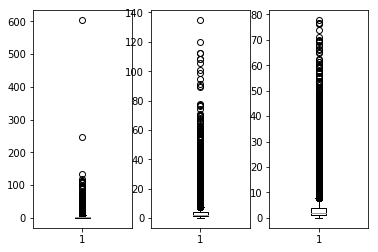

In [12]:
#######distance boxplot

distance = data.map(lambda x:float(x.split(',')[10]))
plt.subplot(1,3,1)
boxdata0=distance.collect()
plt.boxplot(boxdata0)
plt.subplot(1,3,2)
boxdata1=distance.filter(lambda x: x<150).collect()
plt.boxplot(boxdata1)#### 80
plt.subplot(1,3,3)
boxdata2=distance.filter(lambda x: x<80).collect()
plt.boxplot(boxdata2)

{'boxes': [<matplotlib.lines.Line2D at 0x7fac3bc3d2d0>],
 'caps': [<matplotlib.lines.Line2D at 0x7fac3bc3db10>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fac3bc48690>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fac3bc482d0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fac3bc3d390>,
  <matplotlib.lines.Line2D at 0x7fac3bc3d750>]}

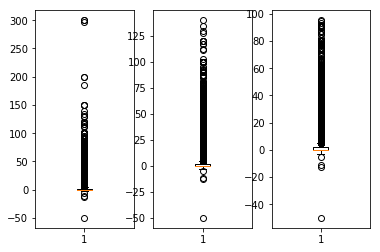

In [13]:
##tip
tip = data.map(lambda x:float(x.split(',')[14]))
plt.subplot(1,3,1)
boxdata0=tip.collect()
plt.boxplot(boxdata0)
plt.subplot(1,3,2)
boxdata1=tip.filter(lambda x: x<150).collect()
plt.boxplot(boxdata1)
plt.subplot(1,3,3)
boxdata2=tip.filter(lambda x: x<100).collect()
plt.boxplot(boxdata2)



{'boxes': [<matplotlib.lines.Line2D at 0x7fac3be5e210>],
 'caps': [<matplotlib.lines.Line2D at 0x7fac3bebce50>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fac3bebc7d0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fac3bebc5d0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fac3be5e6d0>,
  <matplotlib.lines.Line2D at 0x7fac3be5e1d0>]}

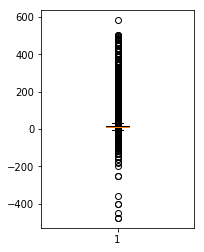

In [14]:
total_amount = data.map(lambda x:float(x.split(',')[18]))
plt.subplot(1,2,1)
boxdata0=total_amount.collect()
plt.boxplot(boxdata0)


## TASK1 

In [15]:
cleandata.map(lambda x:(x[0],x[14])).groupByKey().map(lambda x: (x[0], [i for i in x[1]])).map(lambda x: (x[0], np.mean(x[1]))).collect()

[(u'1', 1.2637729173667895), (u'2', 1.2197907380374333)]

## TASK2

(0, 80)

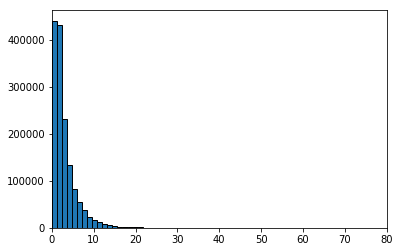

In [16]:

plt.hist(distance.collect(),edgecolor = 'black',bins=500)
plt.xlim(0,80)


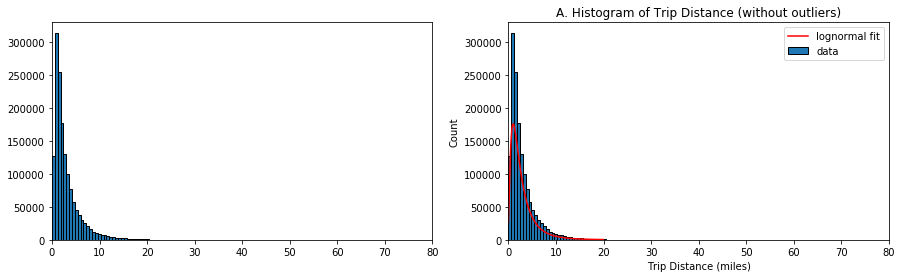

In [17]:
fig,ax = plt.subplots(1,2,figsize = (15,4)) 
ax[0].hist(distance.collect(),edgecolor = 'black',bins=1000)
ax[0].set_xlim(0,80)
from scipy.stats import ttest_ind, f_oneway, lognorm, levy, skew, chisquare
#import scipy.stats as st
from sklearn.preprocessing import normalize, scale
ax[1].set_xlabel('Trip Distance (miles)')
ax[1].set_ylabel('Count')
ax[1].set_title('A. Histogram of Trip Distance (without outliers)')
ax[1].hist(distance.collect(),edgecolor = 'black',bins=1000)
ax[1].set_xlim(0,80)

# apply a lognormal fit. Use the mean of trip distance as the scale parameter
scatter,loc,mean = lognorm.fit(distance.collect(),
                               scale=np.mean(distance.collect()),
                               loc=0)
pdf_fitted = lognorm.pdf(np.arange(0,20,.1),scatter,loc,mean)
ax[1].plot(np.arange(0,20,.1),600000*pdf_fitted,'r') 
ax[1].legend(['lognormal fit','data'])
plt.show()

## TASK3

### 3.a: Report mean trip distance grouped by pick-up hour of day

1474281
1494926
Zero Distance Percentage:  -1.40034362513 %
[(0, 3.150601761915518), (1, 3.0547178763061287), (2, 3.0918459112523715), (3, 3.24245941089649), (4, 3.5840649999999994), (5, 4.2144831796813), (6, 4.129753036437247), (7, 3.330973158416081), (8, 3.0883752856480133), (9, 3.0406914937114626), (10, 2.988157722570948), (11, 2.962297096387053), (12, 2.9522249397357174), (13, 2.9287731071605636), (14, 2.913751888534497), (15, 2.9038419340610875), (16, 2.8222205538872207), (17, 2.7099475174366408), (18, 2.6859567332229273), (19, 2.7444056583929317), (20, 2.8075480549581573), (21, 3.0297802236320934), (22, 3.221327848887191), (23, 3.226619993157368)]
[(0, 3.150601761915518), (1, 3.0547178763061287), (2, 3.0918459112523715), (3, 3.24245941089649), (4, 3.5840649999999994), (5, 4.2144831796813), (6, 4.129753036437247), (7, 3.330973158416081), (8, 3.0883752856480133), (9, 3.0406914937114626), (10, 2.988157722570948), (11, 2.962297096387053), (12, 2.9522249397357174), (13, 2.928773107160

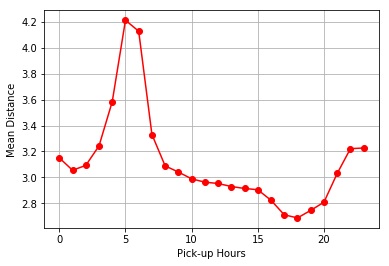

In [18]:
totalCount = cleandata.count()
nonZeroDistanceCount = distance.count()

print totalCount
print nonZeroDistanceCount
print "Zero Distance Percentage: ",(1 - float(nonZeroDistanceCount)/float(totalCount))*100,"%"

out = cleandata.map(lambda x:(x[1].hour, x[10])).groupByKey().map(lambda x: (x[0], [i for i in x[1]])).map(lambda x: (x[0], np.mean(x[1]))).takeOrdered(24, lambda x:x[0])
#print out.count()
print out

orderedOut = sc.parallelize(out)
print orderedOut.collect()
#print orderedOut.take(3)

hours = orderedOut.map(lambda x: x[0]).collect()
muDis = orderedOut.map(lambda x: x[1]).collect()
print len(hours)
print hours
print len(muDis)
print muDis

plt.plot(hours, muDis, 'r-o')
plt.xlabel("Pick-up Hours")
plt.ylabel("Mean Distance")
plt.grid(True)
plt.show()

### 3.b: Report mean trip distance grouped by day of the week

[(1, 3.04133809213999), (2, 2.88431304809992), (3, 2.90751747762548), (4, 2.8779873620873215), (5, 2.9505127819480332), (6, 3.141268600016365), (7, 3.2161006606716827)]
[(1, 3.04133809213999), (2, 2.88431304809992), (3, 2.90751747762548), (4, 2.8779873620873215), (5, 2.9505127819480332), (6, 3.141268600016365), (7, 3.2161006606716827)]
[3.04133809213999, 2.88431304809992, 2.90751747762548, 2.8779873620873215, 2.9505127819480332, 3.141268600016365, 3.2161006606716827]
7


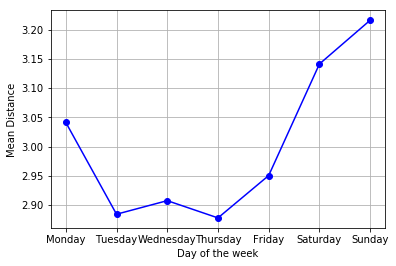

In [19]:
weekDataOut = cleandata.map(lambda x:(x[1].isoweekday(),x[10])).groupByKey().map(lambda x: (x[0], [i for i in x[1]])).map(lambda x: (x[0], np.mean(x[1]))).takeOrdered(7, lambda x:x[0])
print weekDataOut

weekDataOutRDD = sc.parallelize(weekDataOut)
print weekDataOutRDD.collect()

weekMuDis = weekDataOutRDD.map(lambda x: x[1]).collect()
print weekMuDis
print len(weekMuDis)
weekDays = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

plt.plot(weekDays, weekMuDis, 'b-o')
plt.xlabel("Day of the week")
plt.ylabel("Mean Distance")
plt.grid(True)
plt.show()

### 3.c: Report Trip Type grouped by hour of the day
#### Since no missing value for trip type, no need for data clean

[('0', 65593), ('1', 52416), ('10', 55196), ('11', 54548), ('12', 55719), ('13', 55353), ('14', 64194), ('15', 71243), ('16', 76682), ('17', 85671), ('18', 94719), ('19', 93861), ('2', 40056), ('20', 88459), ('21', 84443), ('22', 82680), ('23', 77877), ('3', 30717), ('4', 25435), ('5', 15795), ('6', 21334), ('7', 39958), ('8', 56471), ('9', 59534)]
[('0', 812), ('1', 699), ('10', 1359), ('11', 1279), ('12', 1114), ('13', 1123), ('14', 1333), ('15', 1309), ('16', 1240), ('17', 1215), ('18', 1290), ('19', 1219), ('2', 531), ('20', 1282), ('21', 1144), ('22', 1072), ('23', 1040), ('3', 449), ('4', 565), ('5', 584), ('6', 896), ('7', 1433), ('8', 1730), ('9', 1609)]


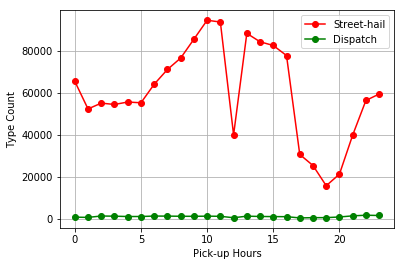

In [20]:

f1 = cleandata.map(lambda x:(x[1].hour , str(x[20]),1)).filter(lambda x: x[1] == '1').map(lambda x: (str(x[0])+"_"+x[1],x[2])).reduceByKey(lambda x,y: x+y).map(lambda x: (x[0].split("_")[0],x[1])).takeOrdered(24, lambda x:x[0])
f2 = cleandata.map(lambda x:(x[1].hour , str(x[20]),1)).filter(lambda x: x[1] == '2').map(lambda x: (str(x[0])+"_"+x[1],x[2])).reduceByKey(lambda x,y: x+y).map(lambda x: (x[0].split("_")[0],x[1])).takeOrdered(24, lambda x:x[0])

f1RDD = sc.parallelize(f1)
f2RDD = sc.parallelize(f2)
print f1RDD.collect()
print f2RDD.collect()

f1Count = f1RDD.map(lambda x:x[1]).collect()
f2Count = f2RDD.map(lambda x:x[1]).collect()

plt.plot(hours, f1Count, 'r-o',label='Street-hail')
plt.plot(hours, f2Count, 'g-o',label='Dispatch')
plt.legend()
plt.xlabel("Pick-up Hours")
plt.ylabel("Type Count")
plt.grid(True)
plt.show()

### 3.d: Report mean Tolls amount grouped by hour of the day # 

### #There is no record with negative Tolls amount, so need for data clean.

[(0, 0.08669844138242604), (1, 0.07283159182905019), (2, 0.071221327025895), (3, 0.08509305011871911), (4, 0.1384269230769231), (5, 0.24733561267476645), (6, 0.2726770130454341), (7, 0.22566137566137562), (8, 0.18256249892613524), (9, 0.17176095382954715), (10, 0.1502537353019185), (11, 0.1351066688161642), (12, 0.1415742614326184), (13, 0.13686132162334444), (14, 0.1412074412074412), (15, 0.14258793692799648), (16, 0.13151946818613489), (17, 0.10867746242202428), (18, 0.09999520878250996), (19, 0.09133950357593605), (20, 0.078951649747607), (21, 0.10606003248156846), (22, 0.11613692807335946), (23, 0.10626620373303597)]
[(0, 0.08669844138242604), (1, 0.07283159182905019), (2, 0.071221327025895), (3, 0.08509305011871911), (4, 0.1384269230769231), (5, 0.24733561267476645), (6, 0.2726770130454341), (7, 0.22566137566137562), (8, 0.18256249892613524), (9, 0.17176095382954715), (10, 0.1502537353019185), (11, 0.1351066688161642), (12, 0.1415742614326184), (13, 0.13686132162334444), (14, 0.14

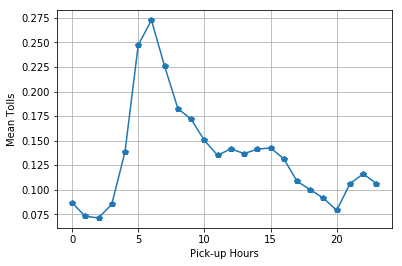

In [21]:


tollsOut = cleandata.map(lambda x:(x[1].hour,abs(x[15]))).groupByKey().map(lambda x: (x[0], [i for i in x[1]])).map(lambda x: (x[0], np.mean(x[1]))).takeOrdered(24, lambda x:x[0])
print tollsOut

tollHourOut = sc.parallelize(tollsOut)
print tollHourOut.collect()

hours = tollHourOut.map(lambda x: x[0]).collect()
muTolls = tollHourOut.map(lambda x: x[1]).collect()

plt.plot(hours, muTolls, 'p-')
plt.xlabel("Pick-up Hours")
plt.ylabel("Mean Tolls")
plt.grid(True)
plt.show()

## TASK4

JFKcount: 12960
JFKAverageFare: 48.5661381173
AllAverageFare: 15.0400449846
JFKAverageDistance: 13.9057407407
AllAverageDistance: 3.00798035788


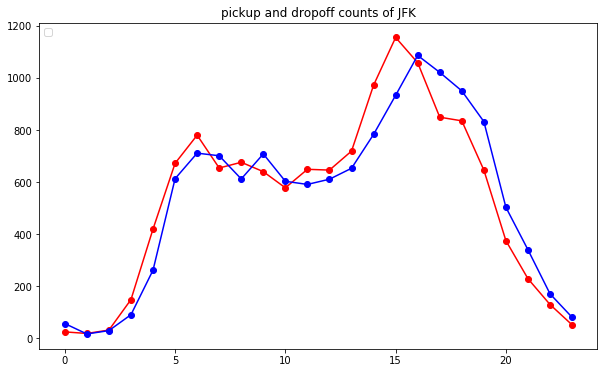

EWRcount: 667
EWRAverageFare: 98.2557121439
EWRAverageDistance: 21.206101949


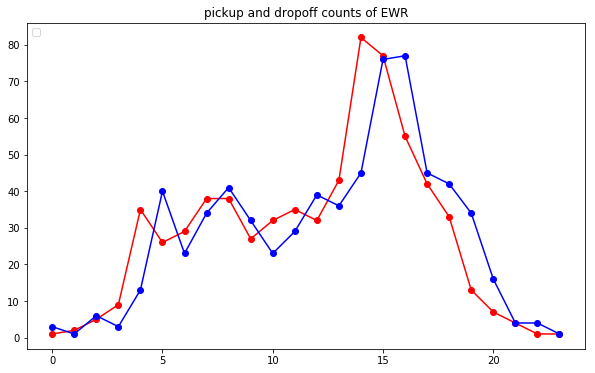

LGAcount: 18418
LGAAverageFare: 25.9480008687
LGAAverageDistance: 6.26010533174


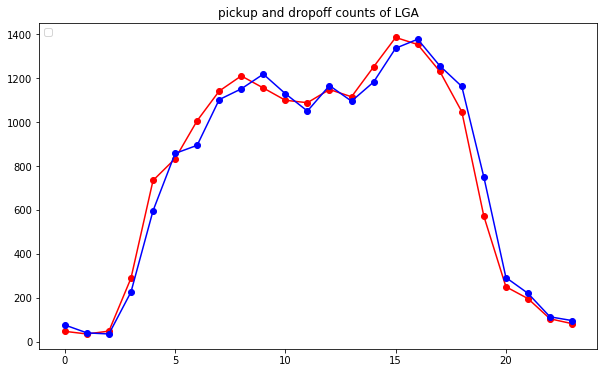

In [22]:
###JFK
JFK_lon = [-73.7757682800293, -73.80748271942139]
JFK_lat = [40.640465334847704, 40.66188943992171]
JFK=cleandata.filter(lambda x: (JFK_lon[1]<x[7]<JFK_lon[0])&(JFK_lat[0]< x[8] <JFK_lat[1]))
print 'JFKcount:', JFK.count()
print 'JFKAverageFare:', JFK.map(lambda x: x[18]).reduce(lambda x,y:x+y)/JFK.count()### mean of total amount for JFKtrips
print 'AllAverageFare:', (cleandata.map(lambda x: x[18]).reduce(lambda x,y:x+y)/cleandata.count())###mean of total amount for all trips
print 'JFKAverageDistance:', JFK.map(lambda x: x[10]).reduce(lambda x,y:x+y)/JFK.count()### mean of distance for JFKtrips
print 'AllAverageDistance:',cleandata.map(lambda x: x[10]).reduce(lambda x,y:x+y)/cleandata.count()

picktime=JFK.map(lambda x: (x[1].hour,1)).reduceByKey(lambda x,y:x+y).sortBy(lambda x:x[0]).collect()
droptime=JFK.map(lambda x: (x[2].hour,1)).reduceByKey(lambda x,y:x+y).sortBy(lambda x:x[0]).collect()

x1=[i[0] for i in picktime]
x2=[i[0] for i in droptime]
y1=[i[1] for i in picktime]
y2=[i[1] for i in droptime]
plt.figure(figsize = (10,6))
plt.plot(x1,y1,'ro-')
plt.plot(x2,y2,'bo-')
plt.legend(loc="upper left")
plt.title('pickup and dropoff counts of JFK')
plt.show()

##EWR
EWR_lon = [-74.17580366134644, -74.1892147064209]
EWR_lat = [40.68704909195378, 40.6956396052937]
EWR=cleandata.filter(lambda x: (EWR_lon[1]<x[7]<EWR_lon[0])&(EWR_lat[0]< x[8] <EWR_lat[1]))
print 'EWRcount:', EWR.count()
print 'EWRAverageFare:', EWR.map(lambda x: x[18]).reduce(lambda x,y:x+y)/EWR.count()### mean of total amount for JFKtrips
print 'EWRAverageDistance:', EWR.map(lambda x: x[10]).reduce(lambda x,y:x+y)/EWR.count()
picktime=EWR.map(lambda x: (x[1].hour,1)).reduceByKey(lambda x,y:x+y).sortBy(lambda x:x[0]).collect()
droptime=EWR.map(lambda x: (x[2].hour,1)).reduceByKey(lambda x,y:x+y).sortBy(lambda x:x[0]).collect()

x3=[i[0] for i in picktime]
x4=[i[0] for i in droptime]
y3=[i[1] for i in picktime]
y4=[i[1] for i in droptime]
plt.figure(figsize = (10,6))
plt.plot(x3,y3,'ro-')
plt.plot(x4,y4,'bo-')
plt.legend(loc="upper left")
plt.title('pickup and dropoff counts of EWR')
plt.show()

##LGA
LGA_lon = [-73.856, -73.888]
LGA_lat = [40.769, 40.789]
LGA=cleandata.filter(lambda x: (LGA_lon[1]<x[7]<LGA_lon[0])&(LGA_lat[0]< x[8] <LGA_lat[1]))
print 'LGAcount:', LGA.count()
print 'LGAAverageFare:', LGA.map(lambda x: x[18]).reduce(lambda x,y:x+y)/LGA.count()### mean of total amount for JFKtrips
print 'LGAAverageDistance:', LGA.map(lambda x: x[10]).reduce(lambda x,y:x+y)/LGA.count()
picktime=LGA.map(lambda x: (x[1].hour,1)).reduceByKey(lambda x,y:x+y).sortBy(lambda x:x[0]).collect()
droptime=LGA.map(lambda x: (x[2].hour,1)).reduceByKey(lambda x,y:x+y).sortBy(lambda x:x[0]).collect()

x5=[i[0] for i in picktime]
x6=[i[0] for i in droptime]
y5=[i[1] for i in picktime]
y6=[i[1] for i in droptime]
plt.figure(figsize = (10,6))
plt.plot(x5,y5,'ro-')
plt.plot(x6,y6,'bo-')
plt.legend(loc="upper left")
plt.title('pickup and dropoff counts of LGA')
plt.show()

In [23]:
tip=JFK.map(lambda x: np.array([float(x[14]),1])).reduce(lambda x,y:x+y)
tip[0]/tip[1]
totaltip=cleandata.map(lambda x: np.array([float(x[14]),1])).reduce(lambda x,y:x+y)
totaltip[0]/totaltip[1]
toll=cleandata.map(lambda x: np.array([float(x[15]),1])).reduce(lambda x,y:x+y)
toll[0]/toll[1]

0.12411905871405617

## TASK5

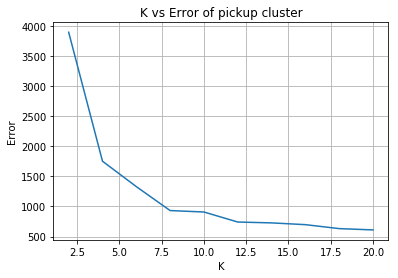

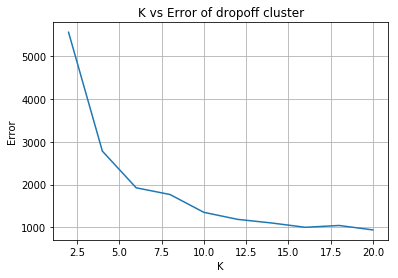

'From the plot, we could see that k =10 is an obvious elbow point, so we chose k = 10 as the optimal k.'

In [120]:
pickup =  cleandata.map(lambda x:(x[6],x[5]))
dropoff = cleandata.map(lambda x:(x[8],x[7]))


ks=[]
ds=[]
for k in [2,4,6,8,10,12,14,16,18,20]:
    clusters = KMeans.train(pickup, k, maxIterations=10, initializationMode="random",seed=111)
    WSSSE=clusters.computeCost(pickup)
    ks.append(k)
    ds.append(WSSSE)
plt.plot(ks,ds)
plt.xlabel('K')
plt.ylabel("Error")
plt.grid(True)
plt.title('K vs Error of pickup cluster')
plt.show()
"""From the plot, we could see that k =8 is an obvious elbow point, so we chose k = 8 as the optimal k."""

ks1=[]
ds1=[]
for k1 in [2,4,6,8,10,12,14,16,18,20]:
    clusters1 = KMeans.train(dropoff, k1, maxIterations=10, initializationMode="random",seed=111)
    WSSSE1=clusters1.computeCost(dropoff)
    ks1.append(k1)
    ds1.append(WSSSE1)

plt.plot(ks1,ds1)
plt.xlabel('K')
plt.ylabel("Error")
plt.grid(True)
plt.title('K vs Error of dropoff cluster')
plt.show()

"""From the plot, we could see that k =10 is an obvious elbow point, so we chose k = 10 as the optimal k."""

In [121]:
clustersk8 = KMeans.train(pickup, 8, maxIterations=10, initializationMode="random",seed=111)
print "pick up cluster Centers are: ", clustersk8.clusterCenters
clustersk10 = KMeans.train(dropoff, 10, maxIterations=10, initializationMode="random",seed=111)
print "drop off cluster Centers are: ", clustersk10.clusterCenters

pick up cluster Centers are:  [array([ 40.66532853, -73.94734975]), array([ 40.74475377, -73.88260581]), array([ 40.68572723, -73.98509473]), array([ 40.80781354, -73.94671997]), array([ 40.76026322, -73.92169972]), array([ 40.72475862, -73.8306424 ]), array([ 40.71785781, -73.9534516 ]), array([ 40.85065985, -73.89938331])]
drop off cluster Centers are:  [array([ 40.6839878 , -73.99005328]), array([ 40.69405474, -73.93390657]), array([ 40.73344165, -73.97859218]), array([ 40.73452291, -73.84643349]), array([ 40.81680665, -73.94162065]), array([ 40.7784058 , -73.95989028]), array([ 40.65159162, -73.95804779]), array([ 40.75609015, -73.89834795]), array([ 40.85561427, -73.88736434]), array([ 40.68145286, -73.78331776])]


## TASK6

2985779


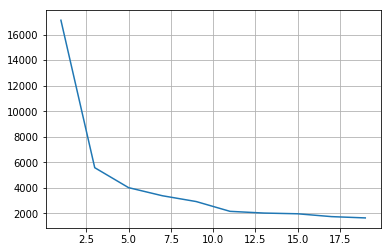

[array([ 40.71159505, -73.95008649]), array([ 40.66059399, -73.9450455 ]), array([ 40.8553188 , -73.91196811]), array([ 40.85112844, -73.85754   ]), array([ 40.82458385, -73.93810343]), array([ 40.69709081, -73.80453904]), array([ 40.7565795 , -73.91338978]), array([ 40.74432874, -73.86360722]), array([ 40.75108913, -73.97855581]), array([ 40.68538619, -73.98715398]), array([ 40.79913144, -73.95099815])]
[(0, 0.12141220096999811), (8, 0.06456271545884676), (1, 0.07516262925018898), (9, 0.15818350922824495), (2, 0.03662494779419374), (10, 0.1776484461843961), (3, 0.01784894327410033), (4, 0.08620463872242386), (5, 0.03518210825382589), (6, 0.12155856143405121), (7, 0.10561129942973006)]


0.26107123132689997

In [13]:
pickup =  data.map(lambda x:(x.split(',')[6],x.split(',')[5])).filter(lambda x: float(x[0])!=0).filter(lambda x:float(x[1])!=0)
dropoff =  data.map(lambda x:(x.split(',')[8],x.split(',')[7])).filter(lambda x: float(x[0])!=0).filter(lambda x:float(x[1])!=0)
allpoint = pickup.collect()+dropoff.collect()

locations = sc.parallelize(allpoint)
print len(allpoint)

ks=[]
es=[]
for k in range(1,20,2):
    clusters = KMeans.train(locations, k, maxIterations=10, initializationMode="random",seed=111)
    WSSSE = clusters.computeCost(locations)
    ks.append(k)
    es.append(WSSSE)
plt.figure()
plt.plot(ks,es)
plt.grid(True)
plt.show()


clusters = KMeans.train(locations, 11, maxIterations=10, initializationMode="random",seed=111)
print clusters.clusterCenters

## the percentage of locations in each cluster
predictions = clusters.predict(locations)
print predictions.map(lambda x:(x,1)).reduceByKey(lambda x,y:x+y).map(lambda x:(x[0],float(x[1])/float(len(allpoint)))).collect()
                                                                      
## pickup and dropoff in the same cluster
samecluster = cleandata.map(lambda x:((x[6],x[5]),(x[8],x[7]))).filter(lambda x:(clusters.predict(x[0])) == (clusters.predict(x[1]))).count()
(2*float(samecluster))/float(len(allpoint))

                                                                                  

# Task 7
In this task, you are expected to group all trips into the following four categories, NJ→NJ, NJ→NYC, NYC→NJ, NYC→NYC. Can you build some association rules on intra- vs. inter-borough traffic? What story does it tell about how New Yorkers use their green taxis?

#### Divide the trips into NJtoNJ, NJtoNYC, NYCtoNJ, NYCtoNYC

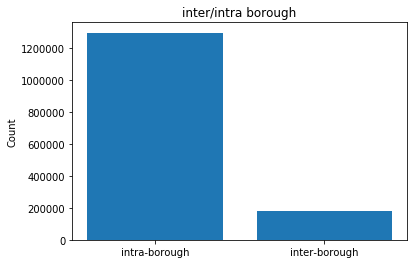

Text(0.5,1,'Trip Categories')

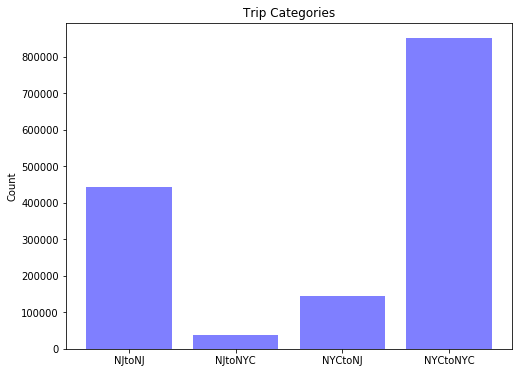

In [24]:
def njnj(lines):
    x1,y1,x2,y2=float(lines[5]),float(lines[6]),float(lines[7]),float(lines[8])
    p1,p2=1.323942*x1+138.669195 - y1,1.323942*x2+138.669195 - y2
    if p1 < 0 and p2 < 0:
        return 1
def njnyc(lines):
    x1,y1,x2,y2=float(lines[5]),float(lines[6]),float(lines[7]),float(lines[8])
    p1,p2=1.323942*x1+138.669195 - y1,1.323942*x2+138.669195 - y2
    if p1 < 0 and p2 > 0:
        return 1
def nycnj(lines):
    x1,y1,x2,y2=float(lines[5]),float(lines[6]),float(lines[7]),float(lines[8])
    p1,p2=1.323942*x1+138.669195 - y1,1.323942*x2+138.669195 - y2
    if p1 > 0 and p2 < 0:
        return 1
def nycnyc(lines):
    x1,y1,x2,y2=float(lines[5]),float(lines[6]),float(lines[7]),float(lines[8])
    p1,p2=1.323942*x1+138.669195 - y1,1.323942*x2+138.669195 - y2
    if p1 > 0 and p2 > 0:
        return 1
def  intraborough(lines):
    x=0
    x1,y1,x2,y2=float(lines[5]),float(lines[6]),float(lines[7]),float(lines[8])
    p1,p2=1.323942*x1+138.669195 - y1,1.323942*x2+138.669195 - y2
    if p1 > 0 and p2 > 0:
        x=x+1
    if p1 < 0 and p2 < 0:
        x=x+1
    return x

def interborough(lines):
    x=0
    x1,y1,x2,y2=float(lines[5]),float(lines[6]),float(lines[7]),float(lines[8])
    p1,p2=1.323942*x1+138.669195 - y1,1.323942*x2+138.669195 - y2
    if p1 < 0 and p2 > 0:
        x=x+1
    if p1 > 0 and p2 < 0:
        x=x+1
    return x
nj_nj = cleandata.filter(njnj).cache()
nj_nyc = cleandata.filter(njnyc).cache()
nyc_nj = cleandata.filter(nycnj).cache()
nyc_nyc = cleandata.filter(nycnyc).cache()
inter_borough = cleandata.filter(interborough).cache()
intra_borough = cleandata.filter(intraborough).cache()
print inter_borough.collect(),intra_borough.collect()
objects = ('intra-borough', 'inter-borough')
y_pos = np.arange(len(objects))
performance = [intra_borough.count(), inter_borough.count()]
plt.bar(y_pos, performance, align='center')
plt.xticks(y_pos, objects)
plt.ylabel('Count')
plt.title('inter/intra borough')
plt.show()

objects = ('NJtoNJ', 'NJtoNYC', 'NYCtoNJ', 'NYCtoNYC')
y_pos = np.arange(len(objects))
performance = [nj_nj.count(), nj_nyc.count(), nyc_nj.count(), nyc_nyc.count()]
plt.figure(figsize=(8,6))
plt.bar(y_pos, performance, align='center', alpha=0.5, color='blue')
plt.xticks(y_pos, objects)
plt.ylabel('Count')
plt.title('Trip Categories')


### Association Rule 1：Traffic Peak Hours: 

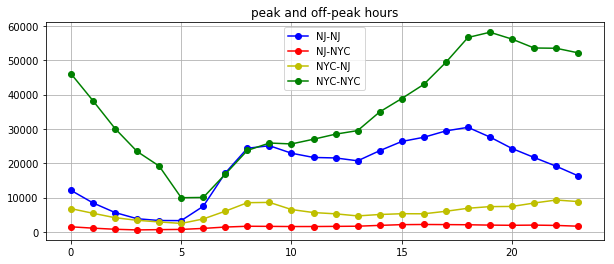

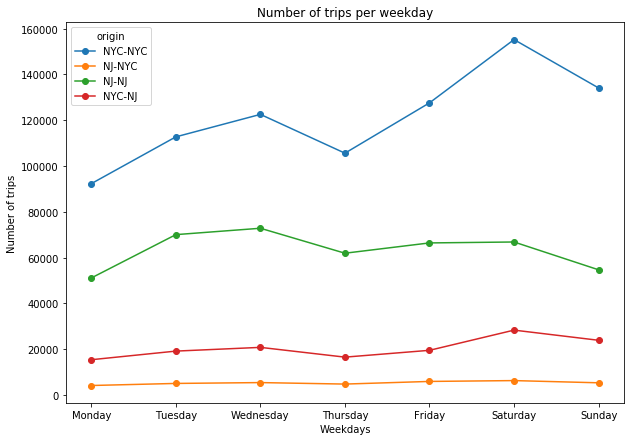

In [25]:
NJtoNJ_peak = nj_nj.map(lambda x:(x[1].hour,1)).reduceByKey(lambda x,y:x+y).sortBy(lambda x:x[0]).collect()
NJtoNYC_peak = nj_nyc.map(lambda x:(x[1].hour,1)).reduceByKey(lambda x,y:x+y).sortBy(lambda x:x[0]).collect()
NYCtoNJ_peak = nyc_nj.map(lambda x:(x[1].hour,1)).reduceByKey(lambda x,y:x+y).sortBy(lambda x:x[0]).collect()
NYCtoNYC_peak = nyc_nyc.map(lambda x:(x[1].hour,1)).reduceByKey(lambda x,y:x+y).sortBy(lambda x:x[0]).collect()

hour= [i[0] for i in NJtoNJ_peak]
NJtoNJ1 = [i[1] for i in NJtoNJ_peak]
NJtoNYC1 = [i[1] for i in NJtoNYC_peak]
NYCtoNJ1 = [i[1] for i in NYCtoNJ_peak]
NYCtoNYC1 = [i[1] for i in NYCtoNYC_peak]


fig=plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax.grid()
ax.set_title('peak and off-peak hours')
ax.legend(loc='best')
ax.plot(hour,NJtoNJ1,'bo-')
ax.plot(hour,NJtoNYC1,'ro-')
ax.plot(hour,NYCtoNJ1,'yo-')
ax.plot(hour,NYCtoNYC1,'go-')
ax.legend(['NJ-NJ','NJ-NYC','NYC-NJ','NYC-NYC'],loc='best')


trip_day_nyny = nyc_nyc.map(lambda x:[x[1].isoweekday(),1]).reduceByKey(lambda x,y:x+y).sortBy(lambda x:x[0]).map(lambda x:x[1]).collect()
trip_day_njny = nj_nyc.map(lambda x:[x[1].isoweekday(),1]).reduceByKey(lambda x,y:x+y).sortBy(lambda x:x[0]).map(lambda x:x[1]).collect()
trip_day_njnj = nj_nj.map(lambda x:[x[1].isoweekday(),1]).reduceByKey(lambda x,y:x+y).sortBy(lambda x:x[0]).map(lambda x:x[1]).collect()
trip_day_nynj = nyc_nj.map(lambda x:[x[1].isoweekday(),1]).reduceByKey(lambda x,y:x+y).sortBy(lambda x:x[0]).map(lambda x:x[1]).collect()

fig,ax = plt.subplots(1,1,figsize=(10,7))
weekDays = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
plt.plot(weekDays, trip_day_nyny,'o-')
plt.plot(weekDays,trip_day_njny,'o-')
plt.plot(weekDays,trip_day_njnj,'o-')
plt.plot(weekDays,trip_day_nynj,'o-')

plt.legend(['NYC-NYC','NJ-NYC','NJ-NJ','NYC-NJ'],title='origin')
plt.xlabel('Weekdays')
plt.ylabel('Number of trips')
plt.title('Number of trips per weekday')

plt.show()

### Association Rule 2:over 80% of the revenue comes from intra-state rides.

In [26]:
nyc_nyc_avgFee = nyc_nyc.map(lambda x:float(x[18])).collect()
nyc_nj_avgFee = nyc_nj.map(lambda x:float(x[18])).collect()
nj_nyc_avgFee = nj_nyc.map(lambda x:float(x[18])).collect()
nj_nj_avgFee = nj_nj.map(lambda x:float(x[18])).collect()
print "The average fee of NYC-NYC trip is : ", sum(nyc_nyc_avgFee)/len(nyc_nyc_avgFee)
print "The average fee of NYC-NJ trip is : ", sum(nyc_nj_avgFee)/len(nyc_nj_avgFee)
print "The average fee of NJ-NYC trip is : ", sum(nj_nyc_avgFee)/len(nj_nyc_avgFee)
print "The average fee of NJ-NJ trip is : ", sum(nj_nj_avgFee)/len(nj_nj_avgFee)
totalRevenue = float(len(nyc_nyc.collect()))*13.7354682825 + float(len(nyc_nj.collect()))*26.4482311428 + float(len(nj_nyc.collect()))*30.2702383325+ float(len(nj_nj.collect()))*12.6053166343
print "The revenue contribute from NYC-NYC is : ",float(len(nyc_nyc.collect()))*13.7354682825/totalRevenue
print "The revenue contribute from NYC-NJ is : ",float(len(nyc_nj.collect()))*13.7354682825/totalRevenue
print "The revenue contribute from NJ-NYC is : ",float(len(nj_nyc.collect()))*13.7354682825/totalRevenue
print "The revenue contribute from NJ-NJ is : ",float(len(nj_nj.collect()))*13.7354682825/totalRevenue
inter_boroughfee = inter_borough.map(lambda x:float(x[18])).collect()
intra_boroughfee = intra_borough.map(lambda x:float(x[18])).collect()
print "The average fee of inter_borough trip is : ", sum(inter_boroughfee)/len(inter_boroughfee)
print "The average fee of intra_borough trip is : ", sum(intra_boroughfee)/len(intra_boroughfee)

The average fee of NYC-NYC trip is :  13.7252256694
The average fee of NYC-NJ trip is :  26.4669533231
The average fee of NJ-NYC trip is :  30.3954153303
The average fee of NJ-NJ trip is :  12.5898810867
The revenue contribute from NYC-NYC is :  0.526458468283
The revenue contribute from NYC-NJ is :  0.088884319519
The revenue contribute from NJ-NYC is :  0.0227814833155
The revenue contribute from NJ-NJ is :  0.274795217979


In [36]:
inter_boroughfee = inter_borough.map(lambda x:float(x[18])).collect()
intra_boroughfee = intra_borough.map(lambda x:float(x[18])).collect()
print "The average fee of inter_borough trip is : ", sum(inter_boroughfee)/len(inter_boroughfee)
print "The average fee of intra_borough trip is : ", sum(intra_boroughfee)/len(intra_boroughfee)

The average fee of inter_borough trip is :  27.2684179559
The average fee of intra_borough trip is :  13.3358517829


### Association Rule 3: mean tips of inter_borough trips  is 170% greater than intra_borough

In [27]:
nyc_nyc_avgtip = nyc_nyc.map(lambda x:float(x[14])).collect()
nyc_nj_avgtip = nyc_nj.map(lambda x:float(x[14])).collect()
nj_nyc_avgtip = nj_nyc.map(lambda x:float(x[14])).collect()
nj_nj_avgtip = nj_nj.map(lambda x:float(x[14])).collect()
print "The average fee of NYC-NYC tip is : ", sum(nyc_nyc_avgtip)/len(nyc_nyc_avgtip)
print "The average fee of NYC-NJ tip is : ", sum(nyc_nj_avgtip)/len(nyc_nj_avgtip)
print "The average fee of NJ-NYC tip is : ", sum(nj_nyc_avgtip)/len(nj_nyc_avgtip)
print "The average fee of NJ-NJ tip is : ", sum(nj_nj_avgtip)/len(nj_nj_avgtip)
inter_boroughtip = inter_borough.map(lambda x:float(x[14])).collect()
intra_boroughtip = intra_borough.map(lambda x:float(x[14])).collect()
print "The average fee of inter_borough tip is : ", sum(inter_boroughtip)/len(inter_boroughtip)
print "The average fee of intra_borough tip is : ", sum(intra_boroughtip)/len(intra_boroughtip)

The average fee of NYC-NYC tip is :  1.0743616308
The average fee of NYC-NJ tip is :  2.77948293159
The average fee of NJ-NYC tip is :  2.39984071759
The average fee of NJ-NJ tip is :  0.927935277138
The average fee of inter_borough tip is :  2.70203027782
The average fee of intra_borough tip is :  1.02414375042


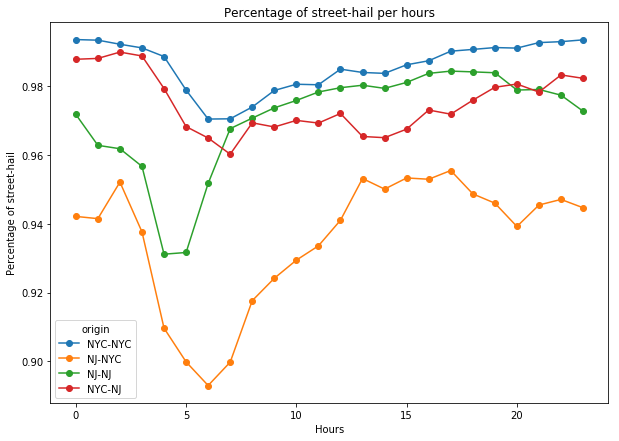

In [28]:
def triptype(x):
    street = 0
    dispatch = 0
    if x[20] == "1":
        street = 1
    if x[20] == "2":
        dispatch = 1
    return [x[1].hour,np.array([street,dispatch])]
street_disPatchnyny = nyc_nyc.map(triptype).reduceByKey(lambda x,y:x+y).map(lambda x:(x[0],float(x[1][0])/(float(x[1][0])+float(x[1][1])))).sortBy(lambda x:x[0]).map(lambda x:x[1]).collect()
street_disPatchnjny = nj_nyc.map(triptype).reduceByKey(lambda x,y:x+y).map(lambda x:(x[0],float(x[1][0])/(float(x[1][0])+float(x[1][1])))).sortBy(lambda x:x[0]).map(lambda x:x[1]).collect()
street_disPatchnjnj = nj_nj.map(triptype).reduceByKey(lambda x,y:x+y).map(lambda x:(x[0],float(x[1][0])/(float(x[1][0])+float(x[1][1])))).sortBy(lambda x:x[0]).map(lambda x:x[1]).collect()
street_disPatchnynj = nyc_nj.map(triptype).reduceByKey(lambda x,y:x+y).map(lambda x:(x[0],float(x[1][0])/(float(x[1][0])+float(x[1][1])))).sortBy(lambda x:x[0]).map(lambda x:x[1]).collect()

h=np.arange(24)
fig,ax = plt.subplots(1,1,figsize=(10,7))

plt.plot(h, street_disPatchnyny,'o-')
plt.plot(h,street_disPatchnjny,'o-')
plt.plot(h,street_disPatchnjnj,'o-')
plt.plot(h,street_disPatchnynj,'o-')

plt.legend(['NYC-NYC','NJ-NYC','NJ-NJ','NYC-NJ'],title='origin')
plt.xlabel('Hours')
plt.ylabel('Percentage of street-hail')
plt.title('Percentage of street-hail per hours')

plt.show()

## Association Rule 4: For those NYC→NYC trips, people are more likely to take taxis from uptown to downtown or from downtown to uptown?

In [29]:
DPUD = cleandata.filter(lambda x: float(x[5]) >= -74.017 and float(x[5]) <= -73.9714 and float(x[6]) >= 40.70 and float(x[6]) <= 40.7917).filter(lambda x: float(x[7]) >= -73.9807 and float(x[7]) <= -73.931346 and float(x[8])>= 40.7917).count()
print DPUD
UPDD = cleandata.filter(lambda x: float(x[7]) >= -74.017 and float(x[7]) <= -73.9714 and float(x[6]) >= 40.70 and float(x[8]) <= 40.7917).filter(lambda x: float(x[5]) >= -73.9807 and float(x[5]) <= -73.931346 and float(x[6])>= 40.7917).count()
print UPDD

231
51000


# Task 8 

### Suggestion 1:Drivers can focus on the locations below to have more opportunities to get customers.
Google map tu

###  Suggestion 2: By clustering for different time periods: 0~3, 4~7, 8~11, 12~15, 16~19, 20~23. We find the buziest 4 clusters, which indicates taxi drivers should go to different clusters during certain time

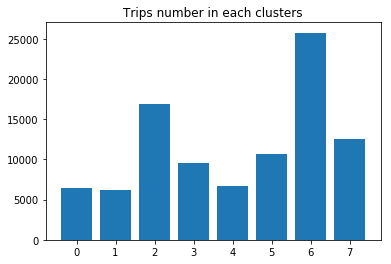

[(2, array([ 40.81920632, -73.93653824])), (4, array([ 40.69595207, -73.92864697])), (7, array([ 40.75082447, -73.89142853])), (2, array([ 40.81920632, -73.93653824])), (6, array([ 40.71699351, -73.95638919])), (5, array([ 40.68255816, -73.98410221])), (7, array([ 40.75082447, -73.89142853])), (7, array([ 40.75082447, -73.89142853])), (2, array([ 40.81920632, -73.93653824])), (0, array([ 40.72621643, -73.83156747])), (1, array([ 40.66343236, -73.95372418])), (5, array([ 40.68255816, -73.98410221])), (2, array([ 40.81920632, -73.93653824])), (2, array([ 40.81920632, -73.93653824])), (2, array([ 40.81920632, -73.93653824]))]


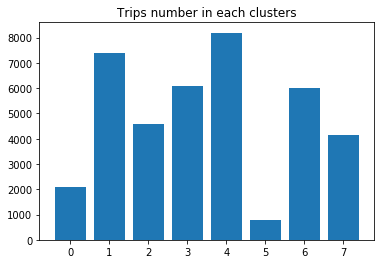

[(6, array([ 40.77970231, -73.93200399])), (7, array([ 40.67222189, -73.94523097])), (1, array([ 40.73926791, -73.86856607])), (1, array([ 40.73926791, -73.86856607])), (3, array([ 40.72411616, -73.95039323])), (7, array([ 40.67222189, -73.94523097])), (7, array([ 40.67222189, -73.94523097])), (4, array([ 40.81808045, -73.94445633])), (1, array([ 40.73926791, -73.86856607])), (4, array([ 40.81808045, -73.94445633])), (0, array([ 40.85847267, -73.91349104])), (6, array([ 40.77970231, -73.93200399])), (2, array([ 40.68561796, -73.98348209])), (3, array([ 40.72411616, -73.95039323])), (0, array([ 40.85847267, -73.91349104]))]


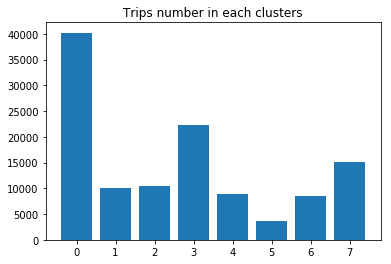

[(7, array([ 40.75923654, -73.91666733])), (2, array([ 40.73427715, -73.85403512])), (0, array([ 40.80463657, -73.94811809])), (7, array([ 40.75923654, -73.91666733])), (5, array([ 40.8508372 , -73.87058376])), (4, array([ 40.6671582 , -73.94878736])), (4, array([ 40.6671582 , -73.94878736])), (0, array([ 40.80463657, -73.94811809])), (3, array([ 40.68734369, -73.98528358])), (0, array([ 40.80463657, -73.94811809])), (3, array([ 40.68734369, -73.98528358])), (7, array([ 40.75923654, -73.91666733])), (2, array([ 40.73427715, -73.85403512])), (7, array([ 40.75923654, -73.91666733])), (3, array([ 40.68734369, -73.98528358]))]


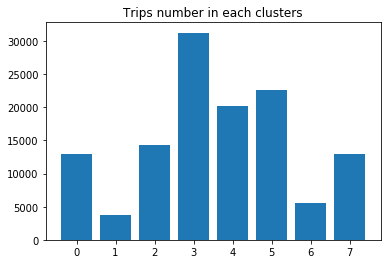

[(7, array([ 40.72890301, -73.84557733])), (6, array([ 40.85417373, -73.88489152])), (6, array([ 40.85417373, -73.88489152])), (7, array([ 40.72890301, -73.84557733])), (5, array([ 40.68611883, -73.98459364])), (3, array([ 40.80079016, -73.94967282])), (2, array([ 40.82848671, -73.93778763])), (3, array([ 40.80079016, -73.94967282])), (2, array([ 40.82848671, -73.93778763])), (5, array([ 40.68611883, -73.98459364])), (3, array([ 40.80079016, -73.94967282])), (3, array([ 40.80079016, -73.94967282])), (1, array([ 40.63886706, -73.95192311])), (5, array([ 40.68611883, -73.98459364])), (4, array([ 40.75534687, -73.90944058]))]


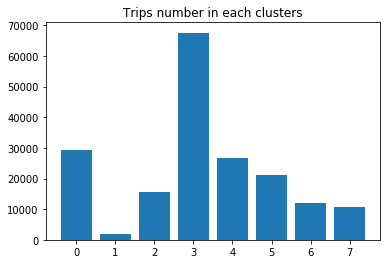

[(5, array([ 40.73060814, -73.84613517])), (4, array([ 40.75533152, -73.90719562])), (6, array([ 40.68127539, -73.9434362 ])), (6, array([ 40.68127539, -73.9434362 ])), (3, array([ 40.8134824, -73.9399954])), (6, array([ 40.68127539, -73.9434362 ])), (2, array([ 40.72474242, -73.95438714])), (3, array([ 40.8134824, -73.9399954])), (3, array([ 40.8134824, -73.9399954])), (7, array([ 40.66721543, -73.98143268])), (3, array([ 40.8134824, -73.9399954])), (0, array([ 40.69111388, -73.98572176])), (7, array([ 40.66721543, -73.98143268])), (3, array([ 40.8134824, -73.9399954])), (7, array([ 40.66721543, -73.98143268]))]


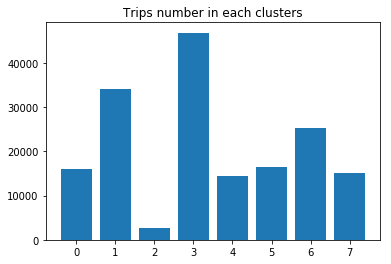

[(3, array([ 40.81447544, -73.93937056])), (2, array([ 40.62428974, -73.96079285])), (0, array([ 40.76017053, -73.92257409])), (0, array([ 40.76017053, -73.92257409])), (1, array([ 40.68544576, -73.98506458])), (3, array([ 40.81447544, -73.93937056])), (5, array([ 40.74522068, -73.88564735])), (0, array([ 40.76017053, -73.92257409])), (0, array([ 40.76017053, -73.92257409])), (3, array([ 40.81447544, -73.93937056])), (6, array([ 40.71947383, -73.95588028])), (3, array([ 40.81447544, -73.93937056])), (3, array([ 40.81447544, -73.93937056])), (3, array([ 40.81447544, -73.93937056])), (3, array([ 40.81447544, -73.93937056]))]


In [45]:
cleandata1 = sdata.filter(lambda x:float(x[5])!=0).filter(lambda x:float(x[6])!=0).filter(lambda x:float(x[7])!=0).filter(lambda x:float(x[8])!=0)
for i,j in [(0,3),(4,7),(8,11),(12,15),(16,19),(20,23)]:

    peak_data = cleandata1.filter(lambda x:i<(int(x[1].split(' ')[1].split(':')[0]))<j).map(lambda x:(x[6],x[5]))

    clusters = KMeans.train(peak_data, 8, maxIterations=10, initializationMode="random",seed=111)

    predictions = clusters.predict(peak_data)
    aa=predictions.map(lambda x:(x,1)).reduceByKey(lambda x,y:x+y).map(lambda x:(x[0],float(x[1]))).sortBy(lambda x:-x[1]).collect()
    plt.bar(*zip(*aa))
    plt.title('Trips number in each clusters' )
    plt.show()

    prediction = peak_data.map(lambda x:(clusters.predict(x),clusters.centers[clusters.predict(x)])).take(15)
    print prediction

###  Suggestion 3: By caluculating the mean of tips for terminating at airport & all trips, and found that trips to airport can receive higher tips

In [30]:

JFK_lon = [-73.7757682800293, -73.80748271942139]
JFK_lat = [40.640465334847704, 40.66188943992171]
JFK=cleandata.filter(lambda x: (float(x[7])<JFK_lon[0])&(float(x[7])>JFK_lon[1])&(float(x[8])<JFK_lat[1])&(float(x[8])>JFK_lat[0]))
JFKtip = JFK.map(lambda x:x[14]).collect()
print 'JFKtip:',stats.describe(JFKtip)


EWR_lon = [-74.17580366134644, -74.1892147064209]
EWR_lat = [40.68704909195378, 40.6956396052937]
EWR=cleandata.filter(lambda x: (float(x[7])<EWR_lon[0])&(float(x[7])>EWR_lon[1])&(float(x[8])<EWR_lat[1])&(float(x[8])>EWR_lat[0]))
EWRtip = EWR.map(lambda x:x[14]).collect()
print 'EWRtip:',stats.describe(EWRtip)

LGA_lon = [-73.856, -73.888]
LGA_lat = [40.769, 40.789]
LGA=cleandata.filter(lambda x: (float(x[7])<LGA_lon[0])&(float(x[7])>LGA_lon[1])&(float(x[8])<LGA_lat[1])&(float(x[8])>LGA_lat[0]))
LGAtip = LGA.map(lambda x:x[14]).collect()
print 'LGAtip:',stats.describe(LGAtip)


Alltip =cleandata.map(lambda x:x[14]).collect()
print 'Alltip:',stats.describe(Alltip)

JFKtip: DescribeResult(nobs=12960, minmax=(0.0, 59.17), mean=5.156707561728394, variance=26.453809584972525, skewness=0.8318984092533266, kurtosis=2.443942347103447)
EWRtip: DescribeResult(nobs=667, minmax=(0.0, 85.0), mean=11.460359820089954, variance=117.33636473519998, skewness=1.1389498689232593, kurtosis=3.8752066788670865)
LGAtip: DescribeResult(nobs=18418, minmax=(0.0, 48.0), mean=3.0705234010207407, variance=10.43054422296868, skewness=1.4973609648811679, kurtosis=8.533865989880152)
Alltip: DescribeResult(nobs=1474281, minmax=(0.0, 95.2), mean=1.229378218941979, variance=4.926843969955325, skewness=6.012752167002241, kurtosis=114.15605642590688)


##Clustering the pick-up locations of the trips terminating at airports, it's more likely that the trips are going to airports

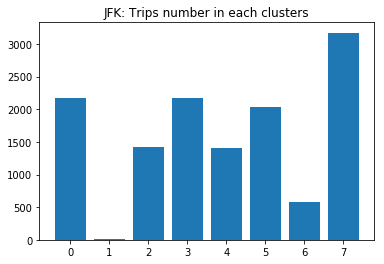

[array([-73.9498283 ,  40.80543111]), array([-73.94862675,  40.70375312]), array([-73.92511994,  40.75552345]), array([-73.97923824,  40.68023821])]


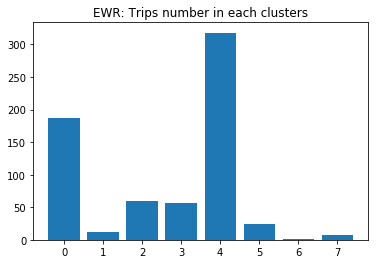

[array([-73.95298535,  40.80891149]), array([-73.97576631,  40.69196155])]


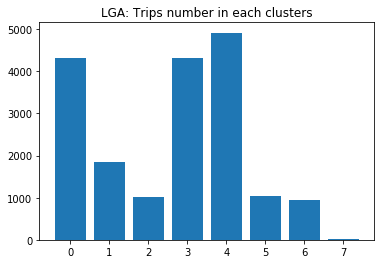

[array([-73.91491951,  40.76284544]), array([-73.9443924 ,  40.81299406]), array([-73.86519928,  40.74405487])]


In [31]:
JFKlocation=JFK.map(lambda x:x[5:7])
EWRlocation=EWR.map(lambda x:x[5:7])
LGAlocation=LGA.map(lambda x:x[5:7])
clusters = KMeans.train(JFKlocation, 8, maxIterations=10, initializationMode="random",seed=111)
predictions = clusters.predict(JFKlocation)
a0=predictions.map(lambda x:(x,1)).reduceByKey(lambda x,y:x+y).sortBy(lambda x:-x[1]).collect()

plt.bar(*zip(*a0))
plt.title('JFK: Trips number in each clusters' )
plt.show()
prediction0 = [clusters.centers[i] for i in [0,3,5,7]]
print prediction0



clusters = KMeans.train(EWRlocation, 8, maxIterations=10, initializationMode="random",seed=111)
predictions = clusters.predict(EWRlocation)
a1=predictions.map(lambda x:(x,1)).reduceByKey(lambda x,y:x+y).sortBy(lambda x:-x[1]).collect()
plt.bar(*zip(*a1))
plt.title('EWR: Trips number in each clusters' )
plt.show()

prediction1 = [clusters.centers[i] for i in [0,4]]
print prediction1

clusters = KMeans.train(LGAlocation, 8, maxIterations=10, initializationMode="random",seed=111)
predictions = clusters.predict(LGAlocation)
a2=predictions.map(lambda x:(x,1)).reduceByKey(lambda x,y:x+y).sortBy(lambda x:-x[1]).collect()
plt.bar(*zip(*a2))
plt.title('LGA: Trips number in each clusters' )
plt.show()

prediction2 = [clusters.centers[i] for i in [0,3,4]]
print prediction2

### Sugeestion 4: By plotting pickup and dropoff counts separately based on 24 hours of a day, and find that the peak hours are 5pm-8pm, and the off-peak hours are 4am-6am.  And Saturdays have the highest demand. We also plot the average speed by hours to show the peaks and off-peaks

[0.042777777777777776, 0.06833333333333333, 0.06833333333333333, 0.07805555555555556, 0.08277777777777778]
[13.792207792207792, 10.829268292682928]
[(0, 14.759504093702024)]


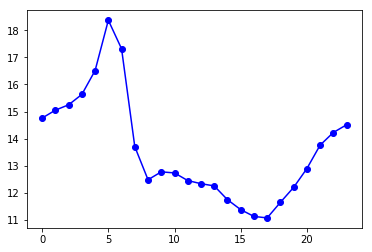

In [26]:
trip_duration=cleandata.map(lambda x:(x[2]-x[1])).map(lambda x:x.total_seconds()/3600.)
print trip_duration.take(5)
distance=cleandata.map(lambda x:x[10])
speed=distance.zip(trip_duration).filter(lambda x:x[1]!=0).map(lambda x:x[0]/x[1])
print speed.take(2)
aaa=cleandata.filter(lambda x: ((x[2]-x[1]).total_seconds()/3600.) !=0).map(lambda x: x[1].hour).zip(speed).filter(lambda x:x[1]<200).groupByKey().map(lambda x: (x[0],np.mean([i for i in x[1]]))).sortBy(lambda x: x[0])
print aaa.take(1)
draw=aaa.collect()
plt.plot([i[0] for i in draw],[i[1] for i in draw],'bo-')


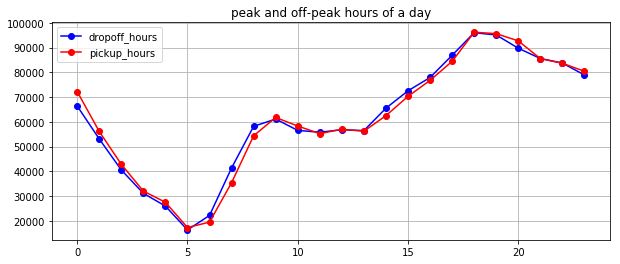

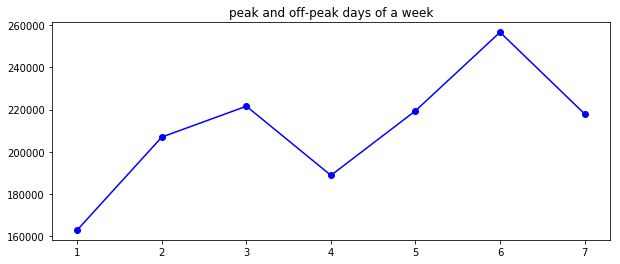

In [33]:
## peak and off-peak hours of a day and a week

pickup_hour = cleandata.map(lambda x:(x[1].hour,1)).reduceByKey(lambda x,y:x+y).sortBy(lambda x:x[0]).collect()
dropoff_hour = cleandata.map(lambda x:(x[2].hour,1)).reduceByKey(lambda x,y:x+y).sortBy(lambda x:x[0]).collect()
hour= [i[0] for i in pickup_hour]
pickup = [i[1] for i in pickup_hour]
dropoff=[i[1] for i in dropoff_hour]

fig=plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax.grid()
ax.set_title('peak and off-peak hours of a day')
ax.legend(loc='best')
ax.plot(hour,pickup,'bo-')
ax.plot(hour,dropoff,'ro-')
ax.legend(['dropoff_hours','pickup_hours'],loc='best')
plt.show()

weekday = cleandata.map(lambda x: (x[1].isoweekday(),1)).reduceByKey(lambda x,y:x+y).collect()
fig=plt.figure(figsize=(10,4))
week= [i[0] for i in weekday]
count = [i[1] for i in weekday]
plt.plot(week,count,'bo-')
plt.title('peak and off-peak days of a week')
plt.show()

### Suggestion 5: Since over 80% of the revenue comes from intra-state rides, company should send more taxi to do intra-state rides.

### Suggesion 6:  By plotting the relationship of MeanTips and Distance, we find that trips have longer distance can receive higher tips

[(1.0, 0.4472294332433719), (2.0, 0.6711668288143482), (3.0, 1.063156809117282), (4.0, 1.4542400921688812), (5.0, 1.8034586057782698), (6.0, 2.1226245786644804), (7.0, 2.4283036407512326), (8.0, 2.862140193035903), (9.0, 3.1419612569952644), (10.0, 3.3499682259488086), (11.0, 3.754447102803738), (12.0, 4.088702070945253), (13.0, 4.321212121212121), (14.0, 4.526227264204013), (15.0, 4.7140802513898965), (16.0, 4.99339184952978), (17.0, 5.0831386138613865), (18.0, 5.523773835920178), (19.0, 6.429206660137121), (20.0, 6.274018181818182), (21.0, 5.8405495978552295), (22.0, 6.107490566037736), (23.0, 5.885229885057471), (24.0, 7.434758620689655), (25.0, 7.428198198198198), (26.0, 8.652869565217392), (27.0, 6.770046948356807), (28.0, 6.851013513513513), (29.0, 7.692783505154639), (30.0, 10.191594202898552), (31.0, 8.079827586206896), (32.0, 6.218947368421053), (33.0, 6.085000000000001), (34.0, 6.526578947368421), (35.0, 8.521304347826087), (36.0, 9.499130434782609), (37.0, 9.741739130434782)

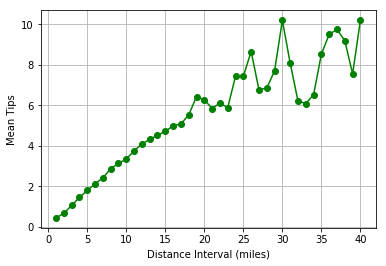

In [34]:

hFilteredData = cleandata.filter(lambda x: float(x[10]) > 0 and float(x[10]) <= 40 ).map(lambda x: (np.ceil(float(x[10])),abs(float(x[14])))).groupByKey().map(lambda x: (x[0], [i for i in x[1]])).map(lambda x:(x[0],np.mean(x[1]))).sortBy(lambda x: x[0])
print hFilteredData.collect()
distances = hFilteredData.map(lambda x: x[0]).collect()
muDisTips = hFilteredData.map(lambda x: x[1]).collect()
print distances
print muDisTips
plt.plot(distances, muDisTips, 'g-o')
plt.xlabel("Distance Interval (miles)")
plt.ylabel("Mean Tips")
plt.grid(True)
plt.show()

In [12]:
sc.stop()